In [2]:
from hydra import initialize_config_dir, compose
from gaze_av_aloha.configs import Config
from omegaconf import OmegaConf
import gaze_av_aloha
from gaze_av_aloha.policies.gaze_policy.gaze_policy import GazePolicy
from gym_av_aloha.datasets.av_aloha_dataset import AVAlohaDataset, AVAlohaDatasetMeta
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Path to your config directory (adjust as needed)
config_dir = os.path.abspath("../../configs")

overrides = [
    "policy=foveated_vit_policy",
    "policy.visualize=False",
]

with initialize_config_dir(config_dir=config_dir, job_name="my_app"):
    cfg: Config = compose(config_name="default", overrides=overrides)


/tmp/ipykernel_2524212/2443815226.py:19: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir=config_dir, job_name="my_app"):


In [3]:
dataset_meta = AVAlohaDatasetMeta(repo_id=cfg.task.dataset_repo_id, root=cfg.task.dataset_root)
policy = GazePolicy(cfg.policy, cfg.task, dataset_meta.stats)
policy.eval()

GazePolicy(
  (normalize_inputs): Normalize(
    (buffer_action): ParameterDict(
        (max): Parameter containing: [torch.FloatTensor of size 21]
        (min): Parameter containing: [torch.FloatTensor of size 21]
    )
    (buffer_observation_state): ParameterDict(
        (max): Parameter containing: [torch.FloatTensor of size 21]
        (min): Parameter containing: [torch.FloatTensor of size 21]
    )
    (buffer_observation_images_zed_cam_left): ParameterDict(
        (mean): Parameter containing: [torch.FloatTensor of size 3x1x1]
        (std): Parameter containing: [torch.FloatTensor of size 3x1x1]
    )
  )
  (unnormalize_outputs): Unnormalize(
    (buffer_action): ParameterDict(
        (max): Parameter containing: [torch.FloatTensor of size 21]
        (min): Parameter containing: [torch.FloatTensor of size 21]
    )
  )
  (flow): FlowModel(
    (backbone): FoveatedViT(
      (tokenizer): FoveatedImageTokenizer(
        (foveator): BatchedFoveator()
        (resize): Resiz

In [4]:

# import gym_av_aloha
# import gymnasium as gym
# env_kwargs = {
#     "disable_env_checker" : True,
#     "fps" : 8.333333333333,
#     "cameras" : {"zed_cam_left" : [480, 640]},
#     "render_camera" : "zed_cam_left" ,
#     "enable_av" : True,
#     "max_episode_steps" : 100,
# }

# viz_env = gym.make(
#     f"gym_av_aloha/thread-needle-v1",
#     **env_kwargs
# )
# obs, info = viz_env.reset(options={"distractors": True})

In [5]:
# viz_env.unwrapped.set_state(state, env_state)
# obs, reward, terminated, truncated, info = viz_env.step(state)
# viz = obs["pixels"]["zed_cam_left"]



In [ ]:

from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
import matplotlib.pyplot as plt

dataset = LeRobotDataset(
    repo_id="iantc104/av_aloha_sim_thread_needle",
    episodes=[51],
)




In [8]:
from gaze_av_aloha.policies.gaze_policy.tokenizer import BaseImageTokenizer, FoveatedImageTokenizer
import torch
import imageio
from tqdm import tqdm
import torchvision
import numpy as np
import cv2

resize  = torchvision.transforms.Resize((286, 358))
resize1  = torchvision.transforms.Resize((288, 384))

video = []

for i in tqdm(range(len(dataset))):
    gaze = dataset[i]["left_eye"].unsqueeze(0)
    img = dataset[i]["observation.images.zed_cam_left"].unsqueeze(0)








    tokenizer = FoveatedImageTokenizer()
    tokens, _ = tokenizer.tokenize(img, gaze)
    blah = tokenizer.generate_visualization(tokens[0])

    blah = blah[:, :-2, :-2]

    fov = (blah.permute(1, 2, 0).numpy() * 255).astype('uint8')

    # tokenizer = FoveatedImageTokenizer()
    tokenizer = BaseImageTokenizer()
    tokens, _ = tokenizer.tokenize(img, gaze)
    blah = tokenizer.generate_visualization(tokens[0])
    blah = blah[:, :-2, :-2]
    fine = (blah.permute(1, 2, 0).numpy() * 255).astype('uint8')


    tokenizer = BaseImageTokenizer(
        token_size = 64,
        height = 256,
        width = 320,
    )
    tokens, _ = tokenizer.tokenize(img, gaze)
    blah = tokenizer.generate_visualization(tokens[0])
    blah = resize(blah.unsqueeze(0)).squeeze(0)
    coarse = (blah.permute(1, 2, 0).numpy() * 255).astype('uint8')

    img = resize(img)
    actual = (img[0].permute(1, 2, 0).numpy() * 255).astype('uint8')
    actual = cv2.cvtColor(actual, cv2.COLOR_RGB2BGR)
    actual = cv2.cvtColor(actual, cv2.COLOR_BGR2RGB)


    x = (gaze[0, 0].item() + 1) /2 * actual.shape[1]
    y = (gaze[0, 1].item() + 1) /2 * actual.shape[0]

    # instead draw a crosshairs with green infill and white outline
    cv2.line(
        actual,
        (int(x - 15), int(y)),
        (int(x + 15), int(y)),
        color=(255, 255, 255),
        thickness=10
    )
    cv2.line(
        actual,
        (int(x), int(y - 15)),
        (int(x), int(y + 15)),
        color=(255, 255, 255),
        thickness=10
    )   
    cv2.line(
        actual,
        (int(x - 15), int(y)),
        (int(x + 15), int(y)),
        color=(0, 255, 0),
        thickness=4
    )
    cv2.line(
        actual,
        (int(x), int(y - 15)),
        (int(x), int(y + 15)),
        color=(0, 255, 0),
        thickness=4
    )


    
    video.append(np.concatenate([
        actual,
        # coarse,
        fov,
        
    ], axis=1))

import imageio
from IPython.display import Video, display

imageio.mimwrite("viz_tokenizer.mp4", video, fps=25)
# Display video in Jupyter
display(Video("viz_tokenizer.mp4", embed=True, width=512, height=384))

100%|██████████| 150/150 [00:06<00:00, 22.37it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (644, 286) to (656, 288) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [40]:
from gaze_av_aloha.policies.gaze_policy.tokenizer import BaseImageTokenizer, FoveatedImageTokenizer
import torch
import imageio
from tqdm import tqdm
import torchvision
import numpy as np
import cv2



video = []

for i in tqdm(range(len(dataset))):
    gaze = dataset[i]["left_eye"].unsqueeze(0)
    img = dataset[i]["observation.images.zed_cam_left"].unsqueeze(0)

    img = (img[0].permute(1, 2, 0).numpy() * 255).astype('uint8')
    # convert to BGR for OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x = (gaze[0, 0].item() + 1) /2 * img.shape[1]
    y = (gaze[0, 1].item() + 1) /2 * img.shape[0]

    # img = cv2.circle(
    #     img,
    #     (int(x), int(y)),
    #     radius=10,
    #     color=(255, 0, 0),
    #     thickness=-1
    # )

    # instead draw a crosshairs with green infill and white outline
    cv2.line(
        img,
        (int(x - 15), int(y)),
        (int(x + 15), int(y)),
        color=(255, 255, 255),
        thickness=10
    )
    cv2.line(
        img,
        (int(x), int(y - 15)),
        (int(x), int(y + 15)),
        color=(255, 255, 255),
        thickness=10
    )   
    cv2.line(
        img,
        (int(x - 15), int(y)),
        (int(x + 15), int(y)),
        color=(0, 255, 0),
        thickness=4
    )
    cv2.line(
        img,
        (int(x), int(y - 15)),
        (int(x), int(y + 15)),
        color=(0, 255, 0),
        thickness=4
    )
    
    video.append(np.concatenate([
        img,
    ], axis=1))

import imageio
from IPython.display import Video, display

imageio.mimwrite("gaze.mp4", video, fps=25)
# Display video in Jupyter
display(Video("gaze.mp4", embed=True, width=512, height=384))

100%|██████████| 150/150 [00:06<00:00, 24.66it/s]


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (930, 286) to (944, 288) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [161]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
import matplotlib.pyplot as plt

dataset = LeRobotDataset(
    repo_id="iantc104/av_aloha_sim_cube_transfer",
    episodes=[51],
)


import gym_av_aloha
import gymnasium as gym
import numpy as np
env_kwargs = {
    "disable_env_checker" : True,
    "fps" : 8.333333333333,
    "cameras" : {"zed_cam_left" : [480, 640]},
    "render_camera" : "zed_cam_left" ,
    "enable_av" : True,
    "max_episode_steps" : 100,
}

viz_env = gym.make(
    f"gym_av_aloha/cube-transfer-v1",
    **env_kwargs
)
np.random.seed(0)
# obs, info = viz_env.reset(options={"distractors": True})
obs, info = viz_env.reset()




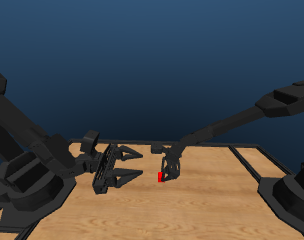

In [162]:
i = 40
state = dataset[i]["observation.state"]
env_state = dataset[i]["observation.environment_state"]

import matplotlib.pyplot as plt

viz_env.unwrapped.set_state(state, env_state)



from IPython.display import Image, display
plt.imsave("temp_image.png", viz_env.render())
display(Image(filename="temp_image.png"))

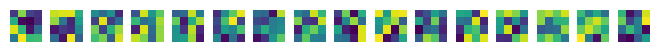

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_tiles = 16
tile_size = 4
gap_size = 1  # Number of columns between tiles

# Generate 4 noise tiles and concatenate them with gaps
tiles = []
for i in range(num_tiles):
    tile = np.random.rand(tile_size, tile_size)
    tiles.append(tile)
    if i < num_tiles - 1:
        # Add gap
        tiles.append(np.ones((tile_size, gap_size)) * np.nan)  # Use NaN for transparent gaps

# Concatenate horizontally
spaced_data = np.hstack(tiles)

# Plot
plt.imshow(spaced_data, cmap='viridis', interpolation='nearest')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('spaced_noise.png', bbox_inches='tight', pad_inches=0)
plt.show()
